# **Final Project Task 4 - Census Modeling Clustering**

Requirements:

Load Data
- Use the preprocessed dataset from Task 1.

Prepare Features
- Feature Selection:
    - Select relevant numerical and categorical features.
    - Note: K-Means works best with numerical data.
- Data Preprocessing:
    - Be sure you have normalized numerical features (e.g., using MinMaxScaler or StandardScaler) and categorical features encoded properly (e.g., One-Hot Encoding or Ordinal Encoding).
    
Clustering Model Implementation
- Apply K-Means Clustering:
    - Experiment with different values of K (number of clusters).
    - Use the Elbow Method to determine the optimal number of clusters:
    - Use yellowbrick.cluster.KElbowVisualizer to find the best K.
    - Calculate the Silhouette Score to evaluate cluster separation.
- Alternative Clustering Approaches:
    - Experiment with Hierarchical Clustering.
    - Experiment with DBSCAN

Visualize & Interpret Clusters
- Dimensionality Reduction:
    - Apply PCA or t-SNE to reduce dimensions and visualize clusters in 2D.
- Cluster Analysis:
    - Plot the clusters in 2D space.
    - Identify key characteristics of each group.
    - Use only numerical variables to interpret the clusters.
- Example insights:
    - "Older individuals tend to work fewer hours per week."
    - "High-income individuals belong to a specific cluster."

Evaluate Cluster Quality
- Silhouette Score:
    - Compute the Silhouette Score to measure cluster compactness and separation. Higher values indicate better clustering results.
- Cluster Distribution:
    - Analyze how well the data points are distributed across clusters.


Deliverables:
- Notebook code with no errors.
- Visualizations & Analysis:
- Elbow method plot for K selection.
- 2D visualization of clusters.
- Summary of cluster characteristics.
- Cluster evaluation metrics (Silhouette Score).






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA



In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

data = pd.read_csv(
    data_url,
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

data.dropna(inplace=True)
data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
numerical_features = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week"
]

categorical_features = [
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country"
]


In [4]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(data)
X_preprocessed.shape


(32561, 91)

In [5]:
inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    inertias.append(kmeans.inertia_)



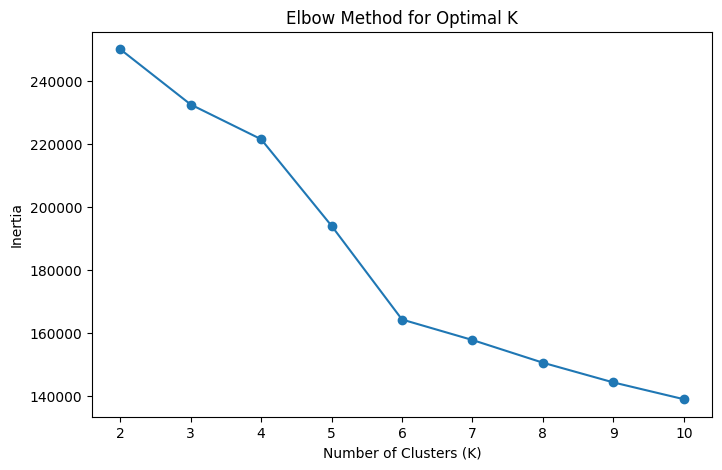

In [6]:
plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


In [7]:
optimal_k = 4


In [ ]:
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_preprocessed)
    silhouette_scores.append(silhouette_score(X_preprocessed, labels))







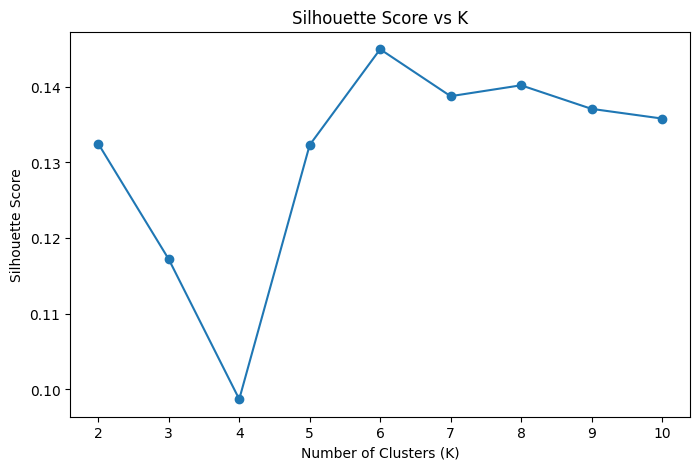

In [9]:
plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.show()


In [10]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
data["cluster"] = kmeans_final.fit_predict(X_preprocessed)


In [11]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed.toarray())

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cluster"] = data["cluster"]


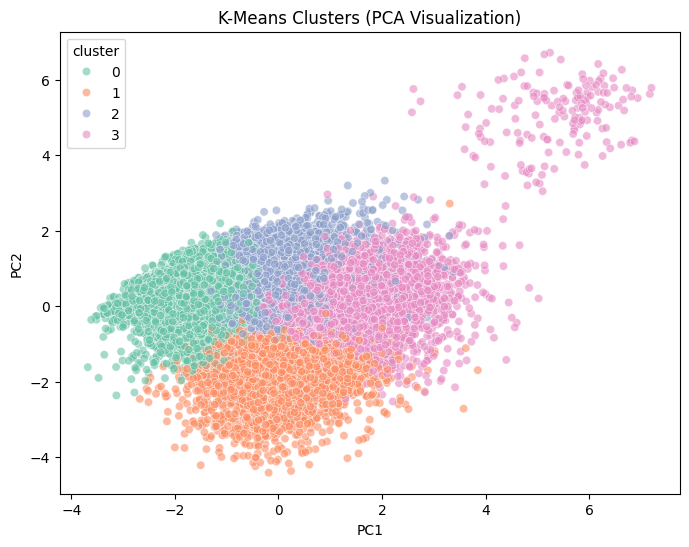

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="Set2",
    alpha=0.6
)
plt.title("K-Means Clusters (PCA Visualization)")
plt.show()


In [13]:
cluster_summary = data.groupby("cluster")[numerical_features].mean()
cluster_summary


,age,education-num,capital-gain,capital-loss,hours-per-week
cluster,,,,,
0,24.278418,8.952027,107.072022,32.265402,32.507872
1,56.113824,7.854937,473.473429,23.405745,34.939677
2,38.176471,11.266581,593.105812,16.724748,43.710218
3,40.620885,11.176131,2553.105101,222.263330,46.853321


In [14]:
final_silhouette = silhouette_score(X_preprocessed, data["cluster"])
final_silhouette


0.09870228320326398

In [15]:
data["cluster"].value_counts(normalize=True)


cluster
3    0.319093
2    0.262093
0    0.247750
1    0.171064
Name: proportion, dtype: float64

In [16]:
agg = AgglomerativeClustering(n_clusters=optimal_k)
agg_labels = agg.fit_predict(X_preprocessed.toarray())

silhouette_score(X_preprocessed, agg_labels)


0.12837105134191037

In [17]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_preprocessed)

mask = dbscan_labels != -1
silhouette_score(X_preprocessed[mask], dbscan_labels[mask])


0.07662227792595831

# Summary

În cadrul acestui proiect am realizat o analiză de tip clustering pe setul de date Census Adult Income, folosind datele preprocesate anterior. 

Au fost selectate variabile numerice relevante precum vârstă, nivel educațional numeric, câștig și pierdere de capital, ore lucrate pe săptămână, alături de variabile categoriale, care au fost codificate prin One-Hot Encoding, iar datele numerice au fost standardizate pentru a asigura comparabilitatea scalelor. Pe baza datelor preprocesate a fost aplicat algoritmul K-Means, testând mai multe valori pentru numărul de clustere. 

Metoda Elbow și scorul Silhouette au indicat un număr optim de 4 clustere, care a fost utilizat în modelul final. Pentru interpretarea rezultatelor, datele au fost proiectate în spațiu bidimensional folosind PCA, permițând vizualizarea clară a separării clusterelor. Analiza mediilor variabilelor numerice pe clustere a evidențiat diferențe între grupuri, precum variații ale vârstei, numărului de ore lucrate și nivelului de educație. În final, calitatea clusterizării a fost evaluată prin scorul Silhouette și distribuția observațiilor pe clustere, iar rezultatele au fost comparate cu metode alternative de clustering, precum Hierarchical Clustering și DBSCAN, confirmând consistența structurii identificate în date.